In [33]:
from promptore_utils import *


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)
    # Simulating argparse in a notebook environment
class Args:
    def __init__(self):
        self.seed = 0  # Random seed
        self.n_rel = 100  # Number of relations/clusters
        self.max_len = 300  # Maximum length of tokens
        self.auto_n_rel = False  # Set to True if you want to estimate the number of clusters
        self.min_n_rel = 777  # Minimum number of relations to estimate (if auto_n_rel=True)
        self.max_n_rel = 1000  # Maximum number of relations to estimate (if auto_n_rel=True)
        self.step_n_rel = 5  # Step size for relation estimation (if auto_n_rel=True)
        self.files = []  # Files to load from Fewrel (leave empty for now)
        self.data = "wikiphi3"

args = Args()

# Read wikiphi3 files
df_dataset = parse_labelstudio("DATA/project-6-at-2025-04-22-13-14-67864b63.json")

# Compute relation embeddings
print("Compute relation embeddings")
relation_embeddings = compute_promptore_relation_embedding(
    df_dataset, template="{sent} {e1} [MASK] {e2} {sent}", max_len=args.max_len, device=device, emb=1)

# Compute clustering
print("Compute clustering")
if args.auto_n_rel:
    n_rel = estimate_n_rel(
        relation_embeddings, args.seed, (args.min_n_rel, args.max_n_rel), args.step_n_rel)
    print(f'Estimated n_rel={n_rel}')
else:
    n_rel = args.n_rel

print("Predict labels")
predicted_labels = compute_kmeans_clustering(relation_embeddings, n_rel, args.seed)

# Evaluation
b3, b3_prec, b3_rec, v, v_hom, v_comp, ari = evaluate_promptore(relation_embeddings, 
                                                                predicted_labels)
print(f'B3: prec={b3_prec} rec={b3_rec} f1={b3}')
print(f'V-measure: hom={v_hom} comp={v_comp} f1={v}')
print(f'ARI={ari}')



cuda
Compute relation embeddings


/home/p0l3/miniconda3/envs/promptore/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at P0L3/clirebert_clirevocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a m

Compute clustering
Predict labels
B3: prec=0.3864786787413925 rec=0.3126922125720155 f1=0.3456919464725939
V-measure: hom=0.6596836986842202 comp=0.6007098957890294 f1=0.6288171054311558
ARI=0.16689009199853538


In [4]:
len(predicted_labels)
relation_embeddings["predicted_labels"] = predicted_labels

In [5]:
relation_embeddings

,input_tokens,input_attention_mask,input_mask,output_r,head,tail,sentence,output_label,embedding,predicted_labels
0,"[tensor(1), tensor(4351), tensor(7712), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",52,is a threat,domoic acid,marine mammal health,The marine algal toxin domoic acid is an impor...,0,"[tensor(-0.0943), tensor(-0.0566), tensor(0.27...",27
1,"[tensor(1), tensor(4351), tensor(7712), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",52,is a,domoic acid,marine algal toxin,The marine algal toxin domoic acid is an impor...,1,"[tensor(0.8001), tensor(0.4366), tensor(0.4597...",27
2,"[tensor(1), tensor(4351), tensor(7712), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",52,exposure can lead to,domoic acid,acute neurologic signs,The marine algal toxin domoic acid is an impor...,2,"[tensor(0.5365), tensor(-0.3253), tensor(1.115...",49
3,"[tensor(1), tensor(4351), tensor(7712), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",52,exposure can lead to,domoic acid,chronic epileptic syndrome,The marine algal toxin domoic acid is an impor...,2,"[tensor(0.4227), tensor(0.0666), tensor(0.5402...",49
4,"[tensor(1), tensor(4351), tensor(7712), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",52,has a negative health effect on,domoic acid,California sea lions,The marine algal toxin domoic acid is an impor...,3,"[tensor(-0.2646), tensor(-0.2021), tensor(-0.5...",27
...,...,...,...,...,...,...,...,...,...,...
1518,"[tensor(1), tensor(4412), tensor(25702), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",42,provided by,Amplex™ Red Uric Acid/Uricase Assay Kit,Molecular Probes,An Amplex™ Red Uric Acid/Uricase Assay Kit fro...,88,"[tensor(0.8554), tensor(-0.0860), tensor(0.838...",74
1519,"[tensor(1), tensor(4412), tensor(25702), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",42,used for,Amplex™ Red Uric Acid/Uricase Assay Kit,solutions,An Amplex™ Red Uric Acid/Uricase Assay Kit fro...,63,"[tensor(0.7897), tensor(-0.4879), tensor(0.749...",122
1520,"[tensor(1), tensor(4412), tensor(25702), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",30,used for,solutions,fluorescence measurements,An Amplex™ Red Uric Acid/Uricase Assay Kit fro...,63,"[tensor(1.1749), tensor(-0.7396), tensor(-0.65...",60
1521,"[tensor(1), tensor(4412), tensor(25702), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",31,performed on,fluorescence measurements,solutions,An Amplex™ Red Uric Acid/Uricase Assay Kit fro...,39,"[tensor(0.6923), tensor(0.5685), tensor(1.0025...",60


In [32]:
relation_embeddings[relation_embeddings["predicted_labels"] == 29].sort_values(by="output_r")[["sentence", "head", "output_r", "tail"]]

,sentence,head,output_r,tail
431,Clinicians should be aware of the potential fo...,normal diet,can cause,subtherapeutic drug levels
413,Prolonged anorexia was associated with relati...,anorexia,causes a change in concentration of,PB
303,"Unexpectedly, when normal food intake resumed,...",normal food intake,causes a decrease in concentration of,PB
414,Prolonged anorexia was associated with relati...,normal food intake,causes a decrease in concentration of,PB
430,Clinicians should be aware of the potential fo...,normal diet,causes a decrease in concentration of,PB
22,Serum levels remained detectable as far as 101...,normal eating,decreases,concentrations
142,Seizures were characterized according to the 2...,International Veterinary Epilepsy Task Force,during period,2015
214,Generalized seizure control was achieved when...,generalized convulsive seizures,has attribute (quantity),17


## Visuals

In [7]:
from sklearn.preprocessing import MinMaxScaler
summary = relation_embeddings.groupby('predicted_labels').agg(
    total_instances=('output_r', 'count'),
    unique_output_r=('output_r', pd.Series.nunique)
).reset_index()



# Apply Min-Max scaling to 'total_instances'
scaler = MinMaxScaler()
summary['total_instances_scaled'] = scaler.fit_transform(summary[['total_instances']])

print(summary)

     predicted_labels  total_instances  unique_output_r  \
0                   0               11                5   
1                   1                7                3   
2                   2               18                7   
3                   3                9                5   
4                   4                4                2   
..                ...              ...              ...   
155               155                5                3   
156               156               12                8   
157               157                9                3   
158               158                9                6   
159               159                8                4   

     total_instances_scaled  
0                  0.303030  
1                  0.181818  
2                  0.515152  
3                  0.242424  
4                  0.090909  
..                      ...  
155                0.121212  
156                0.333333  
157                0.

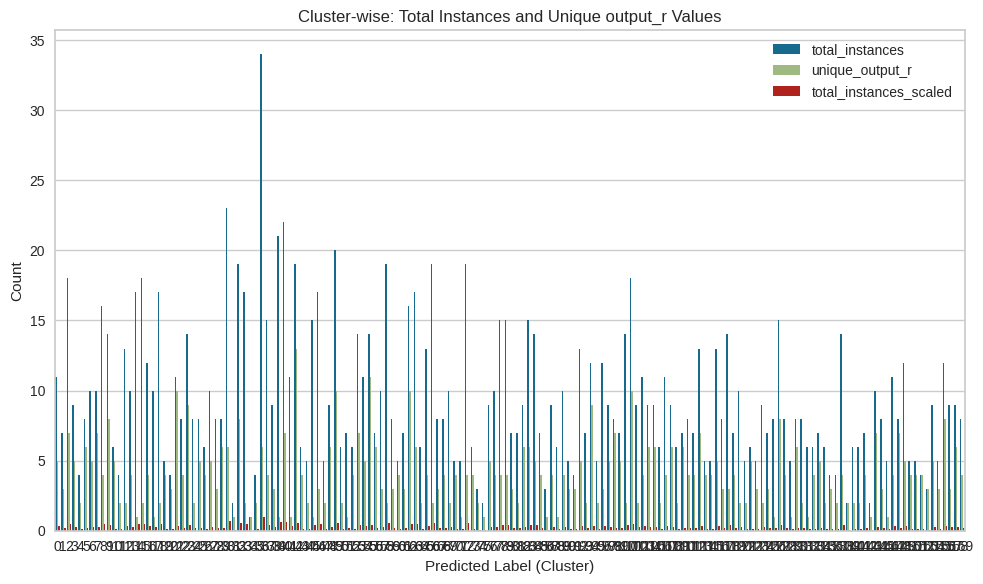

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Bar chart comparing total instances vs unique output_r values
plt.figure(figsize=(10, 6))
sns.barplot(data=summary.melt(id_vars='predicted_labels'), x='predicted_labels', y='value', hue='variable')
plt.title('Cluster-wise: Total Instances and Unique output_r Values')
plt.xlabel('Predicted Label (Cluster)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='')
plt.tight_layout()
plt.show()


/tmp/ipykernel_215656/4177229306.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='predicted_labels', y='diversity_ratio', width=0.5, palette='viridis', order=summary.sort_values(by='diversity_ratio', ascending=False).predicted_labels)


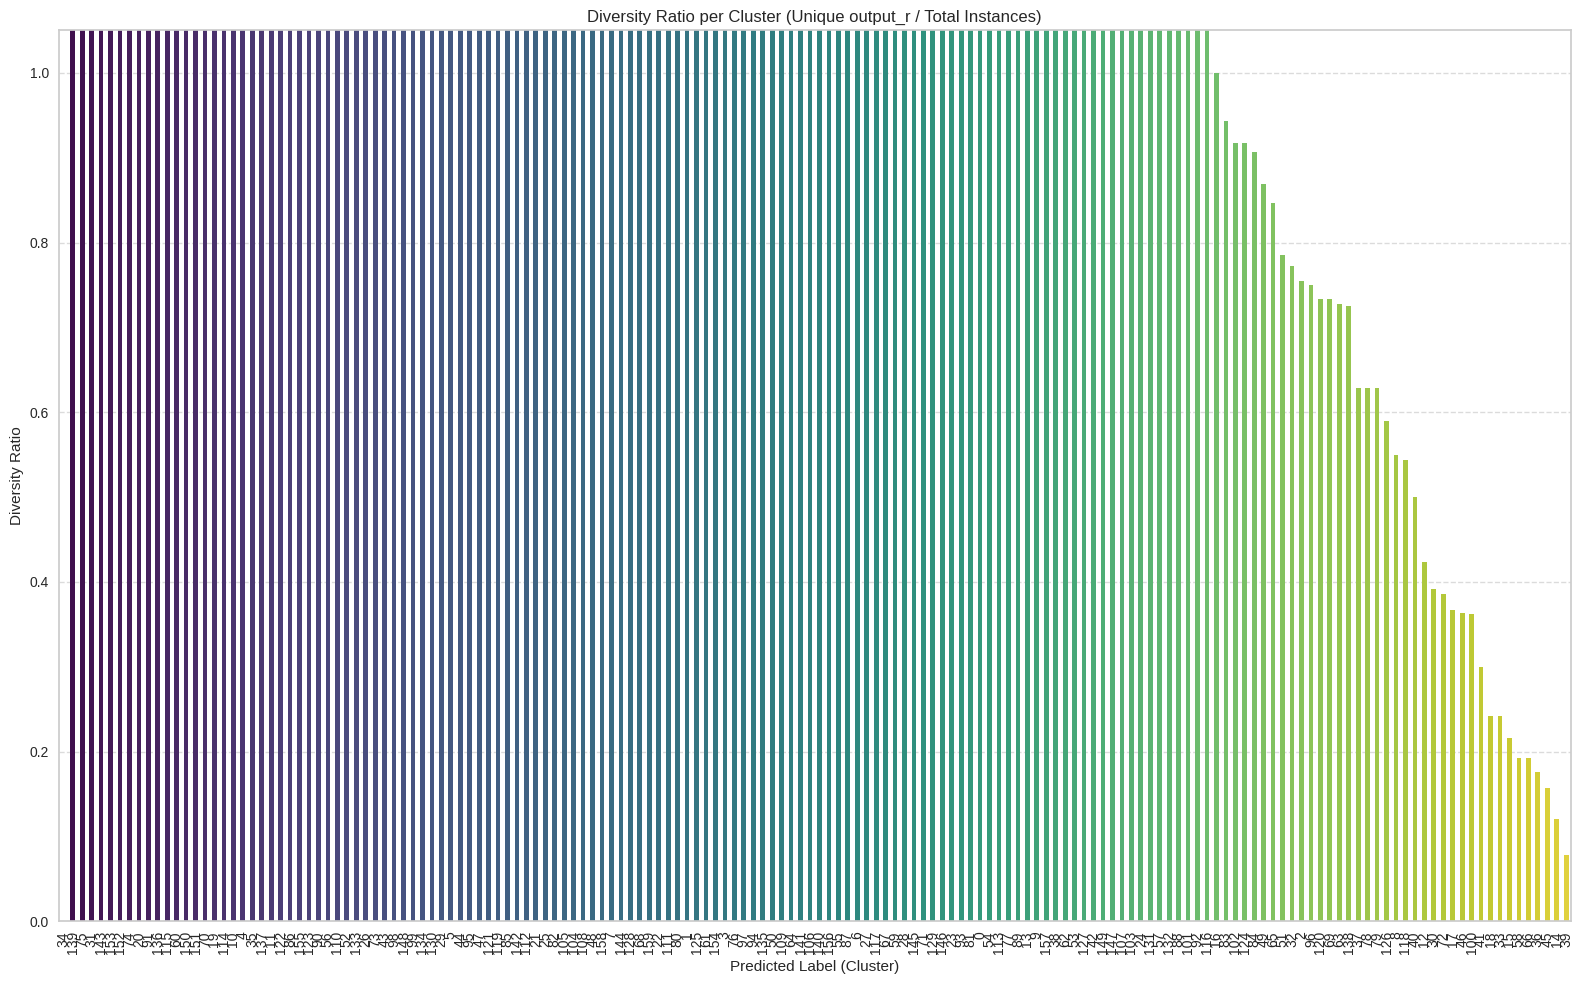

In [9]:
summary['diversity_ratio'] = (summary['unique_output_r'] / summary['total_instances']) / summary["total_instances_scaled"]

summary.sort_values(by='diversity_ratio', ascending=True, inplace=True)
plt.figure(figsize=(16, 10))
sns.barplot(data=summary, x='predicted_labels', y='diversity_ratio', width=0.5, palette='viridis', order=summary.sort_values(by='diversity_ratio', ascending=False).predicted_labels)
plt.title('Diversity Ratio per Cluster (Unique output_r / Total Instances)')
plt.xlabel('Predicted Label (Cluster)')
plt.ylabel('Diversity Ratio')
plt.xticks(rotation = 90)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
summary

,predicted_labels,total_instances,unique_output_r,diversity_ratio
8,8,15,1,0.066667
30,30,14,1,0.071429
158,158,12,1,0.083333
103,103,11,1,0.090909
68,68,30,3,0.100000
...,...,...,...,...
144,144,4,4,1.000000
139,139,4,4,1.000000
117,117,5,5,1.000000
108,108,4,4,1.000000


In [11]:
df_dataset.iloc[1397]

print(df_dataset.iloc[1397]["sent"])
print(df_dataset.iloc[1397]["r"])
print(len(df_dataset.iloc[1397]["sent"]))

for _, a in df_dataset.sample(20).iterrows():
    print(len(a["sent"]))
    

The comparison of the total daily simulation time for Price1, Price2, Price3 and Price0 using GA-EED shows that Price1 achieves a simulation time of 14.23 s, Price2 achieves a simulation time of 13.80 s, Price3 achieves a simulation time of 11.66 s while Price0 achieves a simulation time of 13.61 s. However, GA-EED achieves the lowest operational cost of US$8224.00 compared to US$8238.60 and US$8414.81 for MEED algorithm and PSO respectively.
    
achieves
451
158
78
182
284
204
124
157
142
245
161
299
344
496
129
181
132
201
130
155
68
